In [1]:
from pymatgen.io.lammps.outputs import parse_lammps_log
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
control_path = "monte-carlo-test/mc_batch_testing/control/"

In [21]:
mc_thermo = parse_lammps_log("monte-carlo-test/biased_mc_test/simplified_mc.log")
control_thermo = parse_lammps_log("monte-carlo-test/mc_batch_testing/control/simplified_mc.log")
expanded_cell_thermo = parse_lammps_log("monte-carlo-test/mc_batch_testing/expanded_cell_test/simplified_mc.log")
frozen_thermo = parse_lammps_log("monte-carlo-test/mc_batch_testing/frozen_test/simplified_mc.log")
reduced_disp_thermo = parse_lammps_log("monte-carlo-test/mc_batch_testing/reduced_displacement_test/simplified_mc.log")

In [4]:
len(expanded_cell_thermo)

5

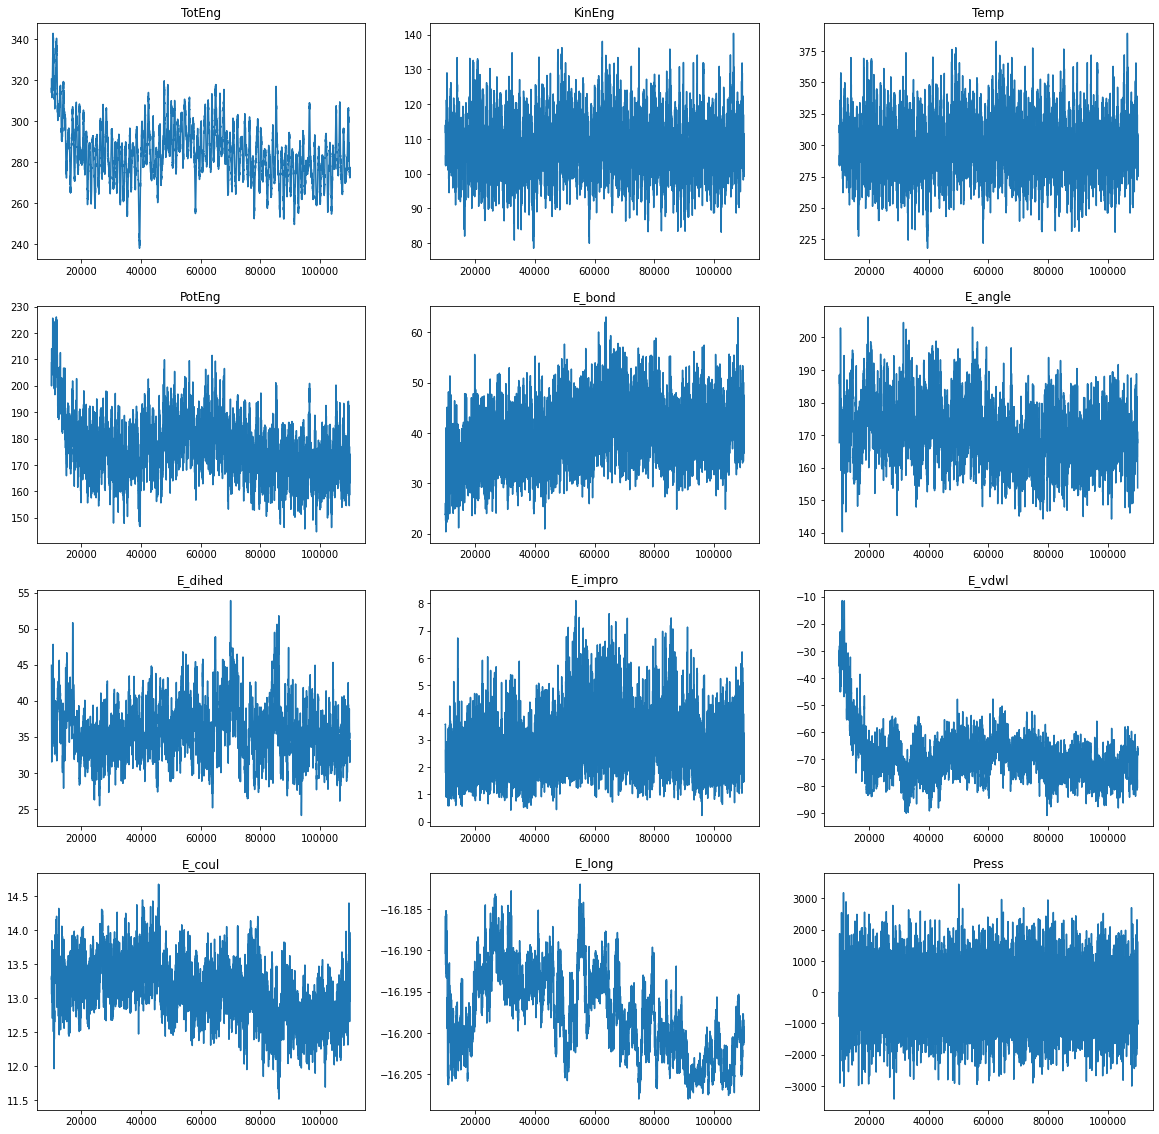

In [5]:
fig, axs = plt.subplots(4,3, figsize=(20,20))
dat = control_thermo[4].columns[1:]
x = control_thermo[4]['Step']

for prop,ax in zip(dat, axs.ravel()):
    ax.set_title(prop)
    ax.plot(x,control_thermo[4][prop])
    # ax.plot(x,expanded_cell_thermo[4][prop], color='black')
    
plt.show()

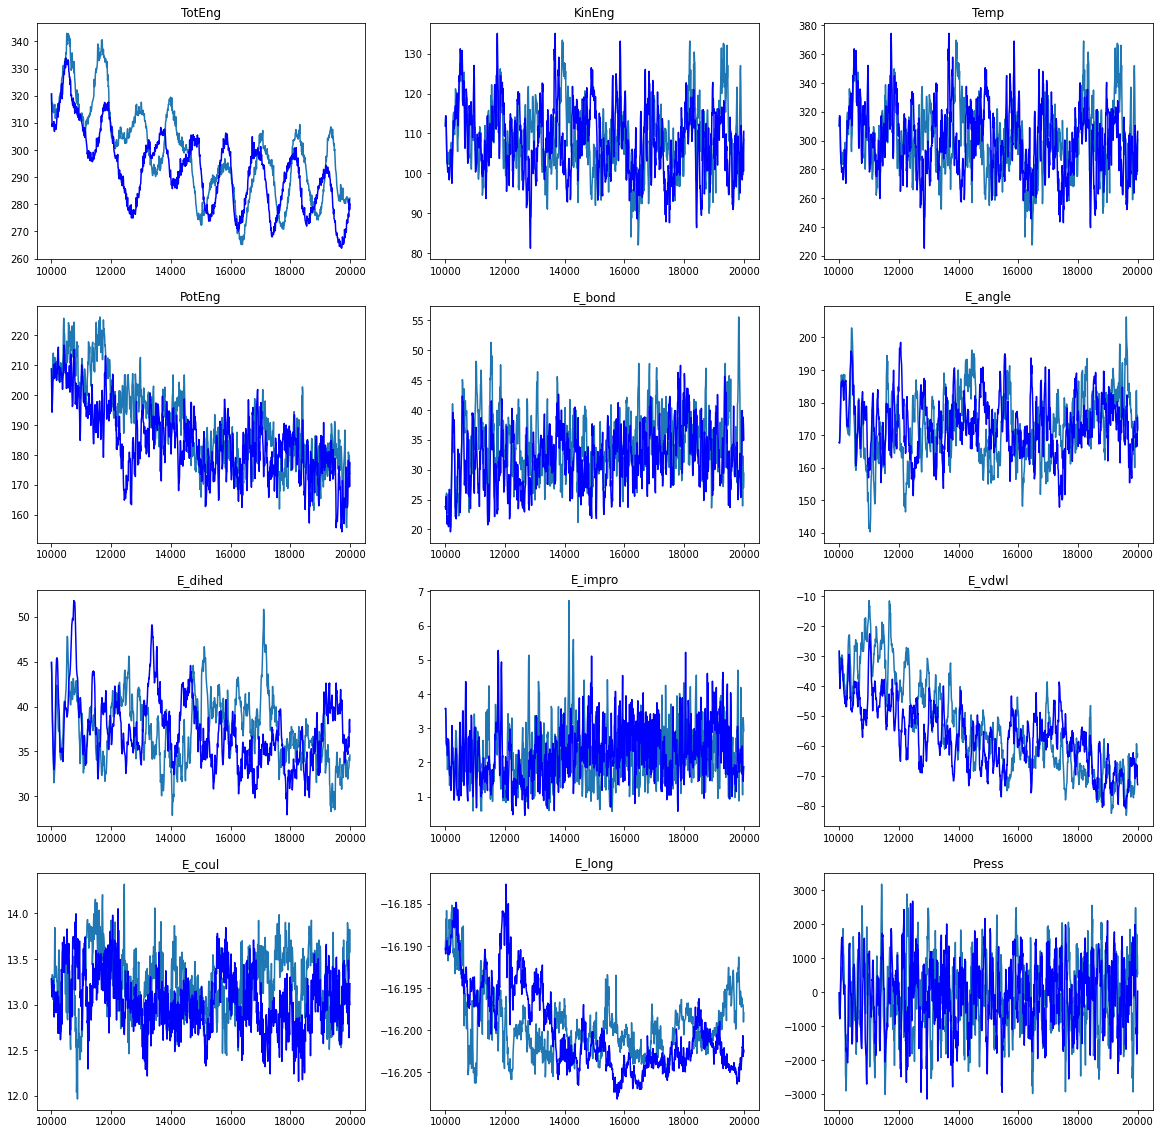

In [6]:
fig, axs = plt.subplots(4,3, figsize=(20,20))
dat = expanded_cell_thermo[4].columns[1:]
x = expanded_cell_thermo[4]['Step']

for prop,ax in zip(dat, axs.ravel()):
    ax.set_title(prop)
    ax.plot(x,control_thermo[4][prop][:1001])
    # ax.plot(x,expanded_cell_thermo[4][prop], color='black')
    ax.plot(x,reduced_disp_thermo[4][prop], color='blue')

plt.show()

In [ ]:
import MDAnalysis as mda
# from MDAnalysis.tests.datafiles import PSF, DCD   # test trajectory
import numpy.linalg

In [ ]:
system = mda.Universe("monte-carlo-test/struct_file/oleic_xlig.mol2", f"monte-carlo-test/mc_batch_testing/control/simplified_mc.simple_mc.lammpsdump")
system2 = mda.Universe("monte-carlo-test/struct_file/oleic_xlig.mol2", "monte-carlo-test/mc_batch_testing/reduced_displacement_test/simplified_mc.simple_mc.lammpsdump")

In [9]:
system.trajectory

<DumpReader monte-carlo-test/mc_batch_testing/control/simplified_mc.simple_mc.lammpsdump with 10001 frames of 122 atoms>

In [10]:
xlig = system.atoms[0:68]
oleic = system.atoms[68:]

Define orientation vectors for the two molecules? This data should actually be extractable from lammps in theory since it's being controlled by the montecarlo fix...

As a proxy, define it as the vector between first and last heavy atom of the molecule?

In [11]:
xlig.radius_of_gyration()

7.117850193820992

In [12]:
xlig_vectors = []
oleic_vectors = []
rgyr_x = []
rgyr_o = []
for ts in system.trajectory:
    vector1 = xlig[-1].position - xlig[0].position
    xlig_vectors.append(vector1)
    vector2 = oleic[-1].position - oleic[0].position
    oleic_vectors.append(vector2)
    rgyr_x.append(xlig.radius_of_gyration())
    rgyr_o.append(oleic.radius_of_gyration())

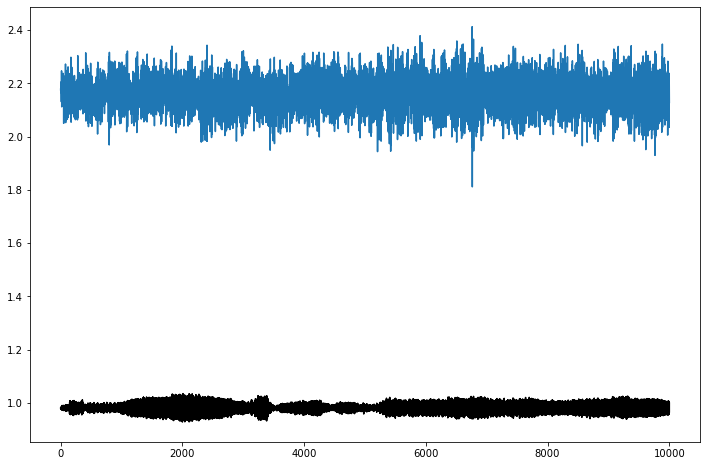

In [14]:
plt.figure(figsize=(12,8))

xlig_backbone = [np.linalg.norm(x) for x in xlig_vectors]
oleic_backbone = [np.linalg.norm(x) for x in oleic_vectors]
x = range(len(xlig_backbone))

plt.plot(x, xlig_backbone)
plt.plot(x, oleic_backbone, color="black")
plt.show()

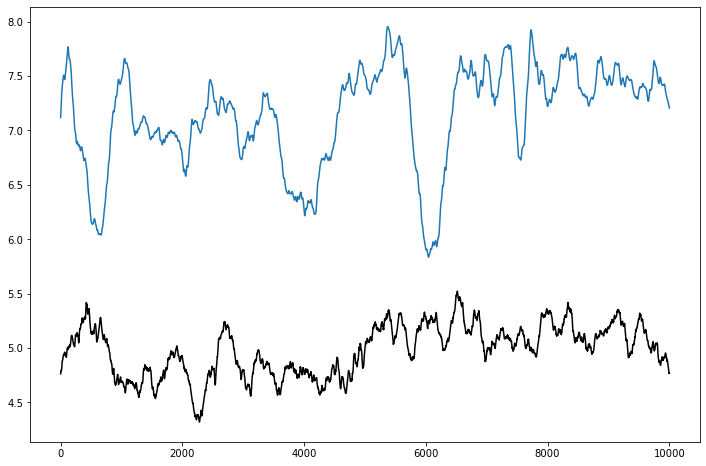

In [15]:
plt.figure(figsize=(12,8))

plt.plot(x, rgyr_x)
plt.plot(x, rgyr_o, color="black")
plt.show()

In [16]:
%%time
oleic_analysis = {
    "COM": [],
    "COG": []
}

xlig_analysis = {
    "COM": [],
    "COG": []
}

for ts in system.trajectory:
    xlig.wrap()
    oleic.wrap()
    oleic_analysis['COM'].append(oleic.center_of_mass())
    oleic_analysis['COG'].append(oleic.center_of_geometry())
    xlig_analysis['COM'].append(xlig.center_of_mass())
    xlig_analysis['COG'].append(xlig.center_of_geometry())

CPU times: user 7.49 s, sys: 151 ms, total: 7.64 s
Wall time: 10.7 s


In [17]:
mass_distance = [np.linalg.norm(xlig_analysis['COM'][i] - oleic_analysis['COM'][i]) for i in range(len(system.trajectory))]
geo_distance = [np.linalg.norm(xlig_analysis['COG'][i] - oleic_analysis['COG'][i]) for i in range(len(system.trajectory))]

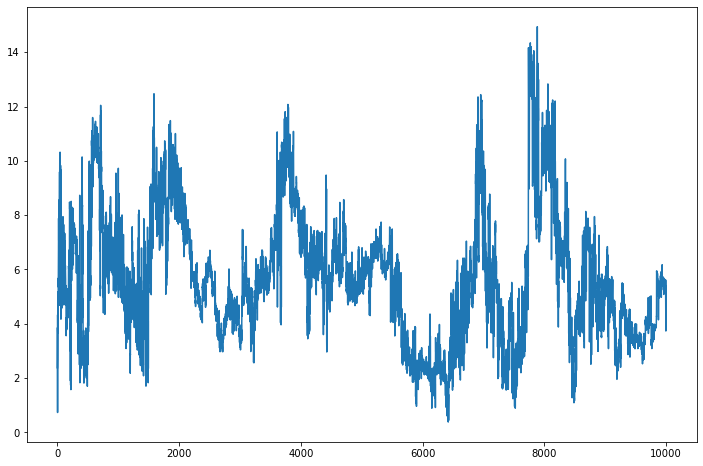

In [18]:
plt.figure(figsize=(12,8))

plt.plot(x,mass_distance)

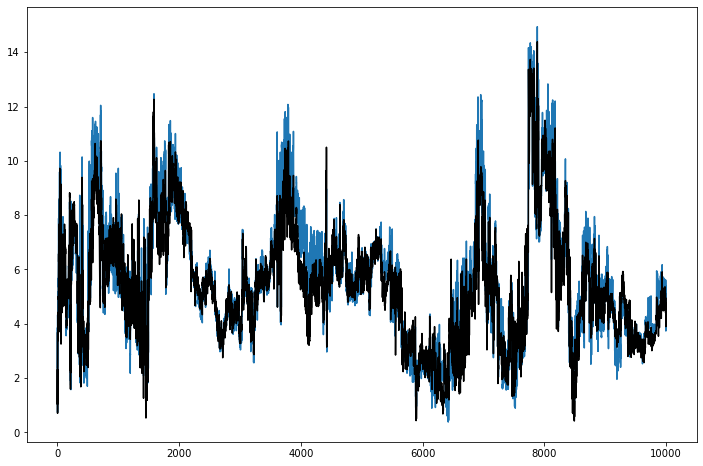

In [19]:
plt.figure(figsize=(12,8))

plt.plot(x,mass_distance)
plt.plot(x,geo_distance, color="black")
plt.show()

IndexError: list index out of range

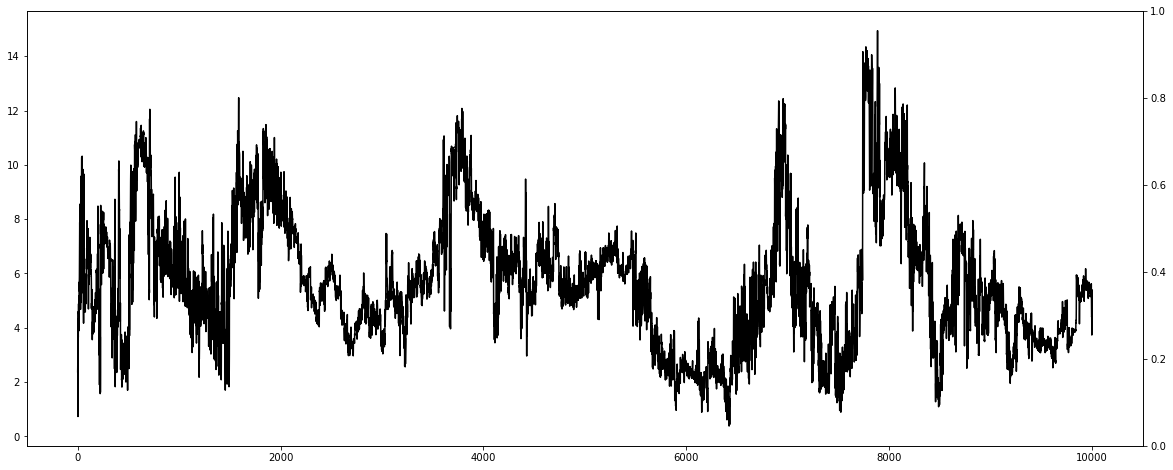

In [22]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(mass_distance, color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()

ax2.plot(mc_thermo[4]['PotEng'], color='blue')
ax2.tick_params(axis='y', labelcolor="blue")

plt.show()

No clear correlation between COM/COGs and energy

Want to check the correlation between ring COM, oleic COM, and energy next

5-membered ring: 1-4, 31

Rings: 1-14, 27-31

In [23]:
fiver = xlig[0:4]
fiver = fiver.concatenate(xlig[30])

In [24]:
for atom in fiver:
    print(atom)

<Atom 1: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 2: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 3: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 4: N of type N.pl3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 31: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>


In [25]:
fiver_com = []

for ts in system.trajectory:
    fiver.wrap()
    fiver_com.append(fiver.center_of_mass())

In [26]:
fiver_mass_distance = [np.linalg.norm(fiver_com[i] - oleic_analysis['COM'][i]) for i in range(len(system.trajectory))]


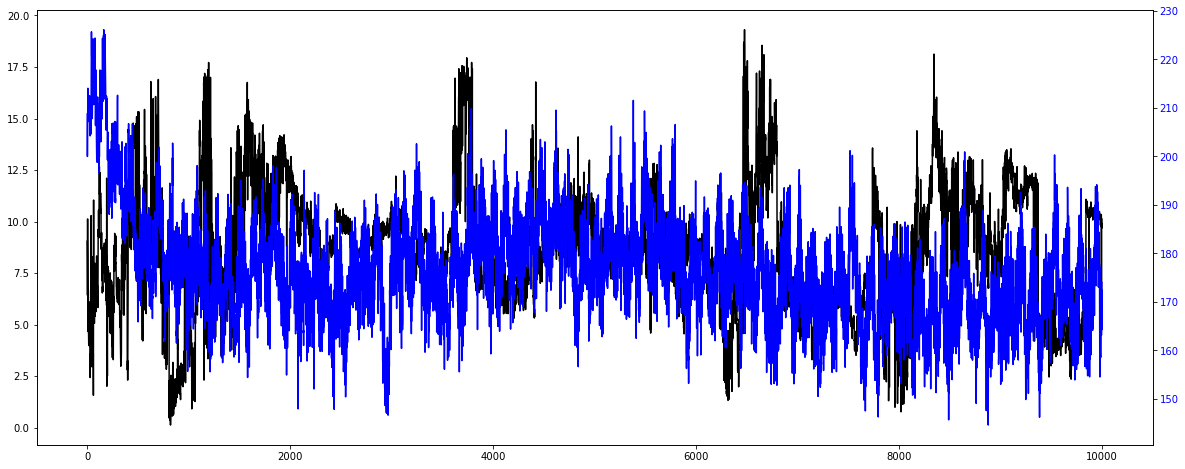

In [36]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(fiver_mass_distance, color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()

ax2.plot(control_thermo[4]['PotEng'], color='blue')
ax2.tick_params(axis='y', labelcolor="blue")

plt.show()

In [28]:
rings = xlig[0:14]
rings = rings.concatenate(xlig[26:31])
rings

<AtomGroup with 19 atoms>

In [29]:
rings_com = []

for ts in system.trajectory:
    rings.wrap()
    rings_com.append(rings.center_of_mass())

In [30]:
rings_mass_distance = [np.linalg.norm(rings_com[i] - oleic_analysis['COM'][i]) for i in range(len(system.trajectory))]


In [38]:
for at in rings:
    print(at)

<Atom 1: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 2: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 3: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 4: N of type N.pl3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 5: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 6: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 7: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 8: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 9: C of type C.2 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 10: O of type O.2 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 11: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 12: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 13: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 14: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 27: C of type C.1 of resname UNL1, resid 1 and segid SYSTEM>
<A

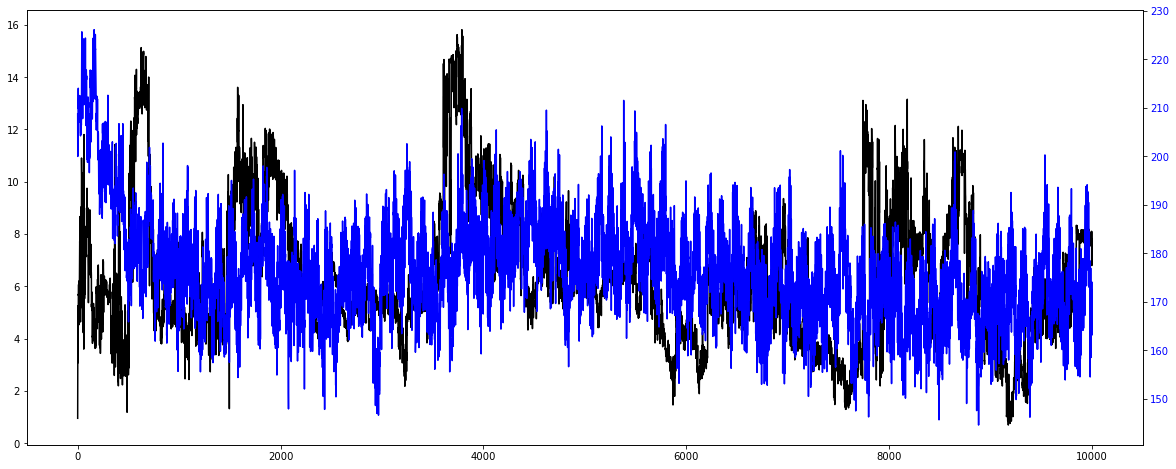

In [35]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(rings_mass_distance, color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()

ax2.plot(control_thermo[4]['PotEng'], color='blue')
ax2.tick_params(axis='y', labelcolor="blue")

plt.show()

In [32]:
xlig2 = system2.atoms[0:68]
oleic2 = system2.atoms[68:]

oleic_analysis2 = {
    "COM": [],
    "COG": []
}

xlig_analysis2 = {
    "COM": [],
    "COG": []
}

for ts in system.trajectory:
    xlig2.wrap()
    oleic2.wrap()
    oleic_analysis2['COM'].append(oleic2.center_of_mass())
    oleic_analysis2['COG'].append(oleic2.center_of_geometry())
    xlig_analysis2['COM'].append(xlig2.center_of_mass())
    xlig_analysis2['COG'].append(xlig2.center_of_geometry())

In [33]:
rings2 = xlig2[0:14]
rings2 = rings2.concatenate(xlig2[26:31])

rings_com2 = []

for ts in system2.trajectory:
    rings2.wrap()
    rings_com2.append(rings2.center_of_mass())
    
rings_mass_distance2 = [np.linalg.norm(rings_com2[i] - oleic_analysis2['COM'][i]) for i in range(len(system2.trajectory))]


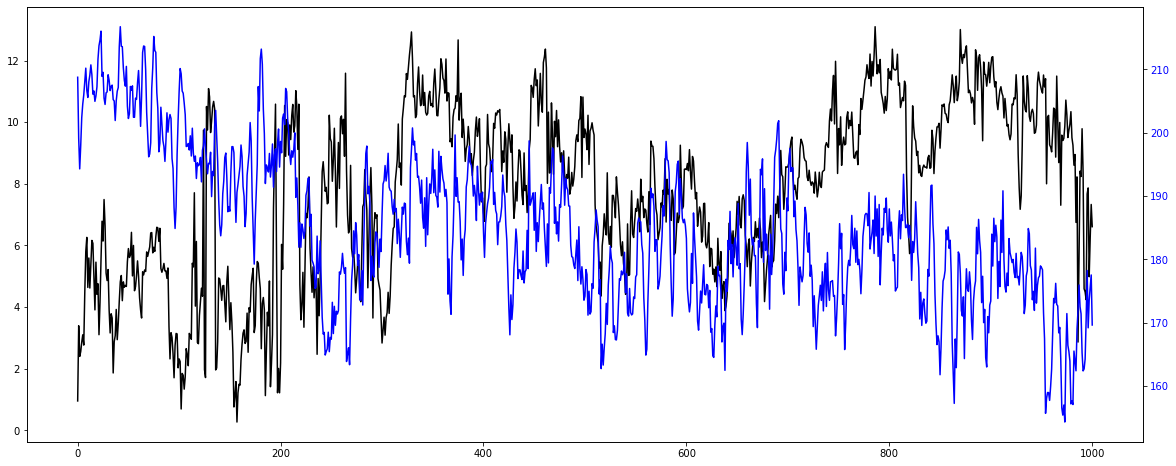

In [34]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(rings_mass_distance2, color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()

ax2.plot(reduced_disp_thermo[4]['PotEng'], color='blue')
ax2.tick_params(axis='y', labelcolor="blue")

plt.show()